In [4]:
from tqdm.auto import tqdm
import torch 
import transformers
from transformers import PreTrainedTokenizer
from transformers import RobertaTokenizer, PreTrainedTokenizer, DistilBertTokenizer, DistilBertModel, RobertaModel
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses, util
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from torch.nn import CosineEmbeddingLoss
import random
from torch.nn import CosineEmbeddingLoss
from torch import nn
#Build up to SBERT model 

In [5]:
deviceNum = 0
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

GRAD_ACC = 6
EPOCHS = 1
FOLDS = 5
SEED = 85
BATCH_SIZE = 5

# Load in Training/Test Data

In [6]:
#get training data 
df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/translated_288_96.tsv", sep="\t", nrows=100)

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#quirk from reusing code 
leanDf = df

#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = 1 - ((leanDf["ground_truth"] - 1) / 3)

#reset index so it is contiguous set of numbers 
leanDf = leanDf.reset_index(drop=True)

In [8]:
#get test data 
#this is the test data that has already had the 
#title concatenated and the head + tail merged
testDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/enTestTranslated_288_96.tsv", sep="\t")

testDf["ground_truth"] = testDf["Overall"]

#rescale ground truth to be between zero and one
#testDf["ground_truth"] = 1 - ((testDf["ground_truth"] - 1) / 3)


(array([96.,  7.,  0., 30.,  1.,  8., 34.,  2.,  8., 50.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

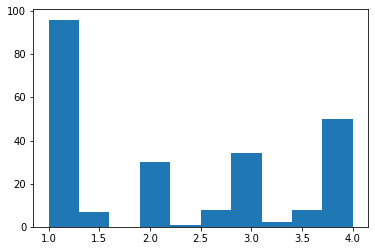

In [9]:
plt.hist(testDf["ground_truth"])

## Bi encoder model 

In [10]:
class BiModel(nn.Module): 
    def __init__(self):
        super(BiModel,self).__init__()
        print(torch.seed())
        self.model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(device).train()
        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-4)
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def forward(self, input_ids, attention_mask): 
        
        input_ids_a = input_ids[0].to(device)
        input_ids_b = input_ids[1].to(device)
        attention_a = attention_mask[0].to(device)
        attention_b = attention_mask[1].to(device)
        
        #encode sentence and get mean pooled sentence representation 
        encoding1 = self.model(input_ids_a, attention_mask=attention_a)[0] #all token embeddings
        encoding2 = self.model(input_ids_b, attention_mask=attention_b)[0]
        
        meanPooled1 = self.mean_pooling(encoding1, attention_a)
        meanPooled2 = self.mean_pooling(encoding2, attention_b)
        
        pred = self.cos(meanPooled1, meanPooled2)
        return pred


## Bi-encoder training function 

In [11]:
def trainBi(trainDataset): 
    print(torch.seed())
    model = BiModel().to(device)
    
    # we would initialize everything first
    optim = torch.optim.Adam(model.parameters(), lr=2e-6)
    
    # and setup a warmup for the first ~10% steps
    total_steps = int(len(trainDataset) / BATCH_SIZE)*EPOCHS
    warmup_steps = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)

    loss_func = torch.nn.MSELoss(reduction="mean")

    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
    
    for epoch in range(EPOCHS):
        print("EPOCH: " + str(epoch))
        
        model.train()  # make sure model is in training mode

        for batch in tqdm(trainLoader):
            optim.zero_grad()
            
            input_ids = [batch["text1Merged_input_ids"], batch["text2Merged_input_ids"]]
            attention_masks = [batch["text1Merged_attention_mask"], batch["text2Merged_attention_mask"]]
            pred = model(input_ids, attention_masks)
            
            gt = batch["ground_truth"].to(device)
            loss = loss_func(pred, gt)
            
            # using loss, calculate gradients and then optimize
            loss.backward()
            optim.step()
            scheduler.step()
            
    return model 

## Load in test dataset for testing 

In [ ]:
#load in our test data 
testDataset = Dataset.from_pandas(testDf[["text1Merged", "text2Merged"]])

#tokenizer
biTokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

all_cols = []
for part in ["text1Merged", "text2Merged"]: 
    #tokenizes each row of the dataset and gives us back tuple of lists 
    testDataset = testDataset.map(lambda x: biTokenizer(x[part], max_length=384, padding="max_length", truncation=True))

    for col in ['input_ids', 'attention_mask']: 
        testDataset = testDataset.rename_column(col, part+'_'+col)
        all_cols.append(part+'_'+col)

testDataset.set_format(type='torch', columns=all_cols)

## Function for testing 

In [12]:
def testModel(trainedModel, testDataset): 
    testLoader = torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=False)
    
    simList = []
    for i, batch in tqdm(enumerate(testLoader)): 
        ids = [batch["text1Merged_input_ids"],batch["text2Merged_input_ids"]]
        masks = [batch["text1Merged_attention_mask"],batch["text2Merged_attention_mask"]]
        sim = trainedModel(ids, masks)
        simList += sim.detach().cpu().tolist()
    
    
    testDf["sims"] = simList
    testDf["scaledSims"] = (3*(1-testDf["sims"])) + 1
    
    corrMat = np.corrcoef(testDf["ground_truth"], testDf["scaledSims"])
    corr = corrMat[0, 1]
    print(corr)
    return [corr, testDf, corrMat]

  0%|          | 0/236 [00:00<?, ?ex/s]

  0%|          | 0/236 [00:00<?, ?ex/s]

## Train model over 5 seeds, save results

In [13]:
MODEL_OUTPUT_STEM = "/shared/3/projects/newsDiffusion/models/2.0-biModelAblation/finalModel/"

seedList = [85, 92, 200, 135, 60]
finalCorrs = {}

for seed in seedList:
    
    #set seeds 
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    #get tokenizer. This is done in the loop so we have random ordering
    transformers.logging.set_verbosity_error()
    biTokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

    print("Train df len: " +  str(len(leanDf)))

    trainDataset = Dataset.from_pandas(leanDf)

    all_cols = ["ground_truth"]
    #NOTE: here we use the merged text
    for part in ["text1Merged", "text2Merged"]: 
        #tokenizes each row of the dataset and gives us back tuple of lists 
        trainDataset = trainDataset.map(lambda x: biTokenizer(x[part], max_length=384, padding="max_length", truncation=True))

        for col in ['input_ids', 'attention_mask']: 
            trainDataset = trainDataset.rename_column(col, part+'_'+col)
            all_cols.append(part+'_'+col)

    trainDataset.set_format(type='torch', columns=all_cols)
    trainedModel = trainBi(trainDataset)
    finalCorrs[seed] = testModel(trainedModel, testDataset)[0]
    
    #save this trained model. We will use the best one in the pipeline 
    torch.save(trainedModel.state_dict(), MODEL_OUTPUT_STEM + str(seed) + "/state_dict.tar")
    
    #just for memory purposes 
    del trainedModel 
    del trainDataset 

Train df len: 100


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

9985177244475411874
8478962953745225685
EPOCH: 0


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0.8238620611982242
Train df len: 100


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

587418569573560914
472571253582557449
EPOCH: 0


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0.8254846657048992
Train df len: 100


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

14636926035914310847
2186919020913630768
EPOCH: 0


  0%|          | 0/20 [00:00<?, ?it/s]

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-13-905773ec7ec1>:31 in <module>                                            │
│ <ipython-input-11-4247d610762b>:33 in trainBi                                             │
│                                                                                           │
│ /opt/anaconda/lib/python3.9/site-packages/torch/_tensor.py:401 in backward                │
│                                                                                           │
│    398 │   │   │   │   retain_graph=retain_graph,                                         │
│    399 │   │   │   │   create_graph=create_graph,                                         │
│    400 │   │   │   │   inputs=inputs)                                                     │
│ ❱  401 │   │   torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs │
│    402 │                                                                                  │
│    403 │   def register_hook(self, hook):                                                 │
│    404 │   │   r"""Registers a backward hook.                                             │
│                                                                                           │
│ /opt/anaconda/lib/python3.9/site-packages/torch/autograd/__init__.py:191 in backward      │
│                                                                                           │
│   188 │   # The reason we repeat same the comment below is that                           │
│   189 │   # some Python versions print out the first line of a multi-line function        │
│   190 │   # calls in the traceback and some print out the last line                       │
│ ❱ 191 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run th │
│   192 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                 │
│   193 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine  │
│   194                                                                                     │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [14]:
corr, testDf, corrMat = testModel(trainedModel, testDataset)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-14-16bccb9d9752>:1 in <module>                                             │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainedModel' is not defined

In [120]:
testDf["simsScaled"] = (3*(1-testDf["sims"])) + 1

In [121]:
np.corrcoef(testDf["simsScaled"], testDf["ground_truth"])

array([[1.        , 0.85752434],
       [0.85752434, 1.        ]])

In [ ]:
#write to an output folder 
RESULTS_PATH = "/shared/3/projects/newsDiffusion/models/2.0-biModelAblation/finalModel/"

import pickle 
with open(RESULTS_PATH + "modelResults.pkl", "wb") as f: 
    pickle.dump(finalCorrs, f)
    